# Imports & Utils

In [ ]:
# Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import cosine_similarity
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import joblib
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [ ]:
def set_seed(seed: int = 42):
    """Set seed for reproducibility across PyTorch, NumPy, and CUDA."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

# Loading in Data

In [ ]:
users = pd.read_csv('users.csv')
users.head()

,id,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,...,Carbohydrates,Fiber,Fat,Acne,Diabetes,Heart Disease,Hypertension,Kidney Disease,Weight Gain,Weight Loss
0,0,25,Male,180,80,Moderately Active,balanced,2000,120,125.0,...,250,30.0,60,0,0,0,0,0,1,0
1,1,32,Female,165,65,Lightly Active,vegetarian,1600,80,100.0,...,200,24.0,40,0,0,1,1,0,1,0
2,2,48,Male,175,95,Sedentary,vegan,2200,100,150.0,...,300,36.0,65,0,0,0,0,0,1,0
3,3,55,Female,160,70,Very Active,balanced,2500,140,175.0,...,350,42.0,80,0,0,0,0,0,1,0
4,4,62,Male,170,85,Sedentary,vegetarian,2000,80,125.0,...,250,30.0,55,0,0,0,0,0,1,0


In [ ]:
meals = pd.read_csv('meals.csv')
meals.head()

,id,title,description,price_cents,diet_type,sugar,calories,fat,protein,fiber,carbohydrates,sodium,allergen_name
0,0,شاورما الدجاج,شرائح دجاج مشوية مع الثوم وصلصة الطحينة وخبز بيتا,28000,balanced,4.0,894.0,37.0,63.0,8.0,76.0,690.0,Gluten
1,1,مسخن,دجاج مع خبز طابون، بصل، وزيت الزيتون,35000,balanced,6.0,1221.0,42.0,84.0,9.0,126.0,1249.0,Gluten
2,2,حمص بطحينة,حمص مهروس مع طحينة، زيت زيتون، وليمون,12000,vegan,10.0,917.0,61.0,27.0,19.0,70.0,75.0,Sesame
3,3,مقلوبة الباذنجان,أرز مع باذنجان مقلي ولحم ضأن,42000,balanced,11.0,1194.0,75.0,60.0,11.0,70.0,179.0,Gluten
4,4,سلطة يونانية,خيار، طماطم، بصل، زيتون، وجبنة فيتا,22000,vegetarian,14.0,654.0,57.0,17.0,4.0,22.0,1496.0,Dairy


In [ ]:
ratings = pd.read_csv('ratings.csv')

# EDA

## Ratings

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82788 entries, 0 to 82787
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  82788 non-null  int64  
 1   meal_id  82788 non-null  int64  
 2   rating   82788 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.9 MB


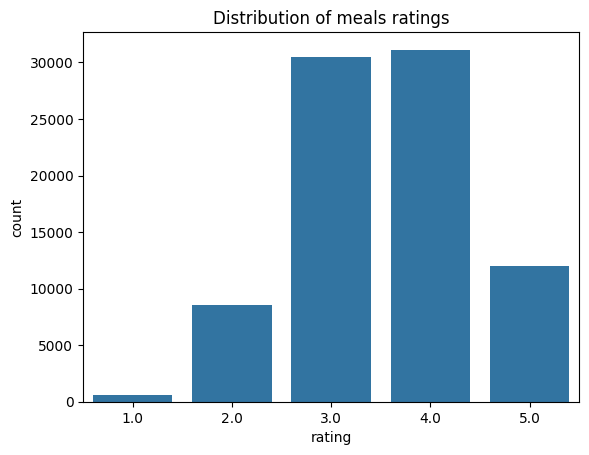

In [ ]:
sns.countplot(data=ratings, x='rating')
plt.title('Distribution of meals ratings')
plt.show()

In [ ]:
global_average_rating = ratings['rating'].mean()
print(f'Global mean rating:{round(global_average_rating, 3)}')

Global mean rating:3.547


In [ ]:
mean_rating_per_user = ratings.groupby("user_id")['rating'].mean()
print(f'Mean rating per user:{round((mean_rating_per_user).mean(), 3)}')

Mean rating per user:3.585


In [ ]:
mean_rating_per_meal = ratings.groupby('meal_id')['rating'].mean()
print(f'Mean rating per meal:{round((mean_rating_per_meal).mean(), 3)}')

Mean rating per meal:3.576


In [ ]:
# Bayesian avg for ratings
average_ratings_per_meal = ratings['meal_id'].value_counts().mean()
C = average_ratings_per_meal

meal_stats = ratings.groupby('meal_id')['rating'].agg(['sum', 'count']).reset_index()
meal_stats.rename(columns={'sum': 'sum_ratings', 'count': 'num_ratings'}, inplace=True)

meal_stats['bayesian_rating'] = round((C * global_average_rating + meal_stats['sum_ratings']) / (C + meal_stats['num_ratings']), 2)

meal_stats = meal_stats.merge(meals, left_on='meal_id', right_index=True)
meal_stats.sort_values(by='bayesian_rating', ascending=False)[['bayesian_rating', 'title']].head(10)

,bayesian_rating,title
215,3.86,شوربة الفطر الكريمية الصحية
220,3.84,مسخن الدجاج بالخبز الأسمر
194,3.83,شوربة العدس بالشعيرية
177,3.83,مقلوبة الباذنجان باللحم البقري
2,3.83,حمص بطحينة
22,3.82,كبة نية
277,3.82,يخني الفاصوليا الخضراء
369,3.81,مسقعة الكوسا بالفرن
331,3.81,صيادية السمك
91,3.81,سمك السلمون المشوي بالبهارات العربية


In [ ]:
meal_ratings = ratings.merge(meals, left_on='meal_id', right_index=True)
meal_ratings['title'].value_counts()[:10]

,count
title,
قلاية بندورة باللحم,253
مندي الدجاج الصحي,252
يخنة الفاصوليا الخضراء باللحم قليل الدسم,251
كبة باللبن المخبوزة,249
فول بالطحينة والليمون,248
سمك بالفرن بالليمون والأعشاب,247
كفتة مشوية بالباذنجان,245
مجبوس دجاج,245
شوربة الفطر الكريمية الصحية,243


## Users

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1698 non-null   int64  
 1   Ages                  1698 non-null   int64  
 2   Gender                1698 non-null   object 
 3   Height                1698 non-null   int64  
 4   Weight                1698 non-null   int64  
 5   Activity Level        1698 non-null   object 
 6   Dietary Preference    1698 non-null   object 
 7   Daily Calorie Target  1698 non-null   int64  
 8   Protein               1698 non-null   int64  
 9   Sugar                 1698 non-null   float64
 10  Sodium                1698 non-null   float64
 11  Calories              1698 non-null   int64  
 12  Carbohydrates         1698 non-null   int64  
 13  Fiber                 1698 non-null   float64
 14  Fat                   1698 non-null   int64  
 15  Acne                 

In [ ]:
users.drop(columns=["id"]).describe()

,Ages,Height,Weight,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Acne,Diabetes,Heart Disease,Hypertension,Kidney Disease,Weight Gain,Weight Loss
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000
mean,43.961720,174.130153,78.064193,2275.171967,139.898115,126.192580,27.979623,2196.440518,252.385159,30.286219,69.700824,0.038869,0.038869,0.170200,0.171967,0.111307,0.979976,0.000589
std,15.915002,13.420936,16.949264,558.812405,53.326588,34.938902,10.665318,571.089569,69.877804,8.385337,21.430707,0.193340,0.193340,0.375919,0.377463,0.314605,0.140122,0.024268
min,18.000000,150.000000,48.000000,1200.000000,50.000000,60.000000,10.000000,990.000000,120.000000,14.400000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,163.250000,64.000000,1800.000000,100.000000,100.000000,20.000000,1770.250000,200.000000,24.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,42.000000,174.000000,78.000000,2200.000000,136.000000,124.000000,27.200000,2146.000000,248.000000,29.760000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,57.000000,185.000000,91.000000,2689.000000,174.000000,150.000000,34.800000,2549.750000,300.000000,36.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,79.000000,200.000000,119.000000,4364.000000,327.000000,218.000000,65.400000,4357.000000,436.000000,52.320000,145.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Meals

In [ ]:
meals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             459 non-null    int64  
 1   title          459 non-null    object 
 2   description    459 non-null    object 
 3   price_cents    459 non-null    int64  
 4   diet_type      459 non-null    object 
 5   sugar          459 non-null    float64
 6   calories       459 non-null    float64
 7   fat            459 non-null    float64
 8   protein        459 non-null    float64
 9   fiber          459 non-null    float64
 10  carbohydrates  459 non-null    float64
 11  sodium         459 non-null    float64
 12  allergen_name  227 non-null    object 
dtypes: float64(7), int64(2), object(4)
memory usage: 46.7+ KB


In [ ]:
meals.drop(columns=["id"]).describe()

,price_cents,sugar,calories,fat,protein,fiber,carbohydrates,sodium
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,27320.261438,9.684096,621.505447,33.037037,32.997821,10.716776,51.956427,243.183007
std,9824.877253,22.264252,320.968032,22.623961,29.428805,7.498643,44.544790,437.398374
min,10000.000000,0.000000,70.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,20000.000000,4.000000,380.000000,18.000000,9.000000,5.000000,23.000000,35.000000
50%,25000.000000,7.000000,572.000000,26.000000,21.000000,9.000000,41.000000,92.000000
75%,32000.000000,11.000000,788.000000,42.000000,56.000000,14.000000,66.500000,216.000000
max,55000.000000,317.000000,1700.000000,119.000000,139.000000,46.000000,386.000000,2771.000000


# Pre-processing

In [ ]:
# @title Hyperparameters
hyperparams = {
    "embedding_dim": 32,
    "nhead": 2,
    "ff_dim": 32,
    "n_layers": 2,
    "dropout_prob": 0.4,
    "emb_dropout": 0.2,
    "epochs": 30,
    "batch": 512,
    "LR": 3e-2,
    "weight_decay": {"embedding_wd": 1e-4, "bias_wd": 0.0, "other_wd": 5e-3},
    "scheduler": {
        "factor": 0.7,
        "patience": 2,
        "threshold": 1e-3,
        "min_lr": 1e-7
    }
}

In [ ]:
# @title Load raw data

DATA_DIR = "."
users = pd.read_csv(os.path.join(DATA_DIR, "users.csv"))
meals = pd.read_csv(os.path.join(DATA_DIR, "meals.csv"))
ratings = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))

# Filter ratings to include only users present in the users DataFrame
ratings = ratings[ratings['user_id'].isin(users['id'])]

# Filter ratings to include only meals present in the meals DataFrame
ratings = ratings[ratings['meal_id'].isin(meals['id'])]

# Convert user_id and meal_id columns to integer type
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['meal_id'] = ratings['meal_id'].astype(int)

In [ ]:
# Train / validation / test split on the ratings

train_ratings, temp_ratings = train_test_split(
    ratings, test_size=0.3, random_state=42) # 70 % train

val_ratings, test_ratings = train_test_split(
    temp_ratings, test_size=0.5, random_state=42) # 15 % val, 15 % test

train_users = users[users["id"].isin(train_ratings["user_id"])]
train_meals = meals[meals["id"].isin(train_ratings["meal_id"])]

In [ ]:
# Data pipelines

#  – user side
USER_CAT = ["Gender", "Activity Level"]
USER_NUM = ["Ages", "Height", "Weight", "Daily Calorie Target",
            "Protein", "Sugar", "Sodium", "Calories",
            "Carbohydrates", "Fiber", "Fat"]
USER_READY = ['Acne','Diabetes','Heart Disease','Hypertension','Kidney Disease',
              'Weight Gain','Weight Loss']

user_preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), USER_CAT),
    ("num", StandardScaler(), USER_NUM),
    ("ready", "passthrough", USER_READY)
])

# Fit on train users
user_preproc.fit(train_users.set_index("id")[USER_CAT + USER_NUM + USER_READY])

# Transform all users with fitted preproc
user_features = user_preproc.transform(
    users.set_index("id")[USER_CAT + USER_NUM + USER_READY]
).astype("float32")


#  – meal side
MEAL_CAT = ["allergen_name"]
MEAL_NUM = ["price_cents", "sugar", "calories", "fat",
            "protein", "fiber", "carbohydrates", "sodium"]

meal_preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), MEAL_CAT),
    ("num", StandardScaler(), MEAL_NUM)
])

# Fit on train meals
meal_preproc.fit(train_meals.set_index("id")[MEAL_CAT + MEAL_NUM])

# Transform all meals with fitted preproc
meal_features = meal_preproc.transform(
    meals.set_index("id")[MEAL_CAT + MEAL_NUM]
).astype("float32")

In [ ]:
# Build look-up tables for quick tensor retrieval
uid_to_idx = {orig_id: idx for idx, orig_id in enumerate(users["id"])}
mid_to_idx = {orig_id: idx for idx, orig_id in enumerate(meals["id"])}

# reverse map
idx_to_mid = {idx: mid for mid, idx in mid_to_idx.items()}
idx_to_uid = {idx: uid for uid, idx in uid_to_idx.items()}

In [ ]:
# @title Description encoding
from sentence_transformers import SentenceTransformer

descriptions = meals["description"].astype(str).tolist()

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
desc_vecs = model.encode(descriptions, batch_size=64, show_progress_bar=True)

save_path = "meal_desc_384.npy"
np.save(save_path, desc_vecs.astype(np.float32))
print("Saved", desc_vecs.shape, "vectors to", save_path)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Saved (459, 384) vectors to meal_desc_384.npy


In [ ]:
# @title MealRating Dataset
class MealRatingDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        u_idx = uid_to_idx[row["user_id"]]
        m_idx = mid_to_idx[row["meal_id"]]
        label = float(row["rating"])

        meal_feat = torch.cat([
            torch.from_numpy(meal_features[m_idx]),
            torch.from_numpy(desc_vecs[m_idx])
        ], dim=0)

        return {
            "user_id" : torch.tensor(u_idx, dtype=torch.long),
            "meal_id" : torch.tensor(m_idx, dtype=torch.long),
            "user_feat" : torch.from_numpy(user_features[u_idx]),
            "meal_feat" : meal_feat,
            "label" : torch.tensor(label, dtype=torch.float32)
        }

train_ds = MealRatingDataset(train_ratings)
val_ds = MealRatingDataset(val_ratings)
test_ds = MealRatingDataset(test_ratings)

BATCH = hyperparams["batch"]
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=BATCH)
test_loader = DataLoader(test_ds,  batch_size=BATCH)

# Hybrid Model

In [11]:
# @title Transformer-based Hybrid Recommender
class HybridRecommender(nn.Module):
    def __init__(self,
                 n_users,
                 n_meals,
                 user_feat_dim,
                 meal_feat_dim,
                 hyperparams):
        super().__init__()
        self.hyperparams = hyperparams
        d = hyperparams["embedding_dim"]

        # embeddings & biases
        self.user_emb = nn.Embedding(n_users, d)
        self.meal_emb = nn.Embedding(n_meals, d)
        self.user_bias  = nn.Embedding(n_users, 1)
        self.meal_bias  = nn.Embedding(n_meals, 1)

        self.user_emb_dropout = nn.Dropout(p=hyperparams["emb_dropout"])
        self.meal_emb_dropout = nn.Dropout(p=hyperparams["emb_dropout"])

        self.user_feat_proj = nn.Linear(user_feat_dim, d)
        self.meal_feat_proj = nn.Linear(meal_feat_dim, d)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d,
            nhead=hyperparams["nhead"],
            dim_feedforward=hyperparams["ff_dim"],
            dropout=hyperparams["dropout_prob"],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer,
                                                 num_layers=hyperparams["n_layers"])

        # final projection to score
        self.out_proj = nn.Linear(d, 1)

    def forward(self, user_ids, meal_ids, user_feats, meal_feats):
        u = self.user_emb_dropout(self.user_emb(user_ids))
        m = self.meal_emb_dropout(self.meal_emb(meal_ids))

        # Project the dense feature vectors to the same dimension d
        u_feat = self.user_feat_proj(user_feats)
        m_feat = self.meal_feat_proj(meal_feats)

        # Stack into a 4-token sequence
        seq = torch.stack([u, m, u_feat, m_feat], dim=1)

        # Transformer forward
        mask = None  # every token to attend to every other token
        x = self.transformer(seq, src_key_padding_mask=mask)

        # Global mean-pool
        pooled = x.mean(dim=1)

        raw_output = self.out_proj(pooled).squeeze(1)

        # Add biases
        u_bias = self.user_bias(user_ids).squeeze(1)
        m_bias = self.meal_bias(meal_ids).squeeze(1)
        return raw_output + u_bias + m_bias

In [ ]:
# Initialize model
n_users = len(uid_to_idx)
n_meals = len(mid_to_idx)

model = HybridRecommender(
    n_users=len(uid_to_idx),
    n_meals=len(mid_to_idx),
    user_feat_dim=user_features.shape[1],
    meal_feat_dim=meal_features.shape[1] + desc_vecs.shape[1],
    hyperparams=hyperparams
).to(device)

In [ ]:
# Train setup
LR = hyperparams["LR"]
embedding_wd = hyperparams["weight_decay"]["embedding_wd"]
bias_wd = hyperparams["weight_decay"]["bias_wd"]
other_wd = hyperparams["weight_decay"]["other_wd"]

# Separate param groups for different weight decays
embedding_params, bias_params, other_params = [], [], []
for name, param in model.named_parameters():
    if "emb" in name: embedding_params.append(param)
    elif "bias" in name: bias_params.append(param)
    else: other_params.append(param)

optimizer = torch.optim.Adam([
    {"params": embedding_params, "weight_decay": embedding_wd},
    {"params": bias_params, "weight_decay": bias_wd},
    {"params": other_params, "weight_decay": other_wd}
], lr=LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=hyperparams["scheduler"]["factor"],
    patience=hyperparams["scheduler"]["patience"],
    threshold=hyperparams["scheduler"]["threshold"],
    min_lr=hyperparams["scheduler"]["min_lr"]
)

loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

def run_epoch(loader, training=False):
    if training: model.train()
    else: model.eval()
    total_loss, total_mae, n = 0.0, 0.0, 0
    for batch in loader:
        user_ids = batch["user_id"].to(device)
        meal_ids = batch["meal_id"].to(device)
        user_feats = batch["user_feat"].to(device)
        meal_feats = batch["meal_feat"].to(device)
        labels = batch["label"].to(device)

        if training: optimizer.zero_grad()
        preds = model(user_ids, meal_ids, user_feats, meal_feats)
        loss = loss_fn(preds, labels)
        mae = mae_fn(preds, labels)
        if training:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * len(labels)
        total_mae  += mae.item() * len(labels)
        n += len(labels)
    rmse = np.sqrt(total_loss / n)
    mae = total_mae / n
    return rmse, mae

In [ ]:
# @title Train
train_rmse_history, val_rmse_history = [], []
train_mae_history,  val_mae_history  = [], []
EPOCHS = hyperparams["epochs"]

for epoch in range(1, EPOCHS+1):
    val_rmse, val_mae = run_epoch(val_loader, training=False)
    train_rmse, train_mae = run_epoch(train_loader, training=True)

    scheduler.step(val_rmse)

    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    train_mae_history.append(train_mae)
    val_mae_history.append(val_mae)

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | "
              f"train RMSE {train_rmse:.4f} | val RMSE {val_rmse:.4f} | "
              f"train MAE {train_mae:.4f} | val MAE {val_mae:.4f}")

Epoch 01 | train RMSE 1.2987 | val RMSE 4.0635 | train MAE 1.0022 | val MAE 3.7111
Epoch 05 | train RMSE 0.8163 | val RMSE 0.8355 | train MAE 0.6515 | val MAE 0.6711
Epoch 10 | train RMSE 0.8182 | val RMSE 0.8303 | train MAE 0.6532 | val MAE 0.6649
Epoch 15 | train RMSE 0.8120 | val RMSE 0.8308 | train MAE 0.6474 | val MAE 0.6570
Epoch 20 | train RMSE 0.8052 | val RMSE 0.8178 | train MAE 0.6415 | val MAE 0.6494
Epoch 25 | train RMSE 0.7978 | val RMSE 0.8198 | train MAE 0.6353 | val MAE 0.6534
Epoch 30 | train RMSE 0.7954 | val RMSE 0.8210 | train MAE 0.6334 | val MAE 0.6491


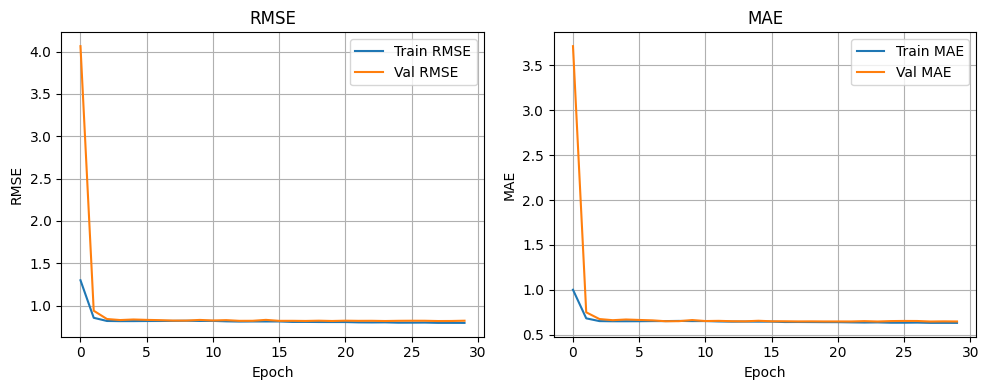

In [ ]:
# @title Plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_rmse_history, label='Train RMSE')
plt.plot(range(EPOCHS), val_rmse_history, label='Val RMSE')
plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.title('RMSE')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_mae_history, label='Train MAE')
plt.plot(range(EPOCHS), val_mae_history, label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

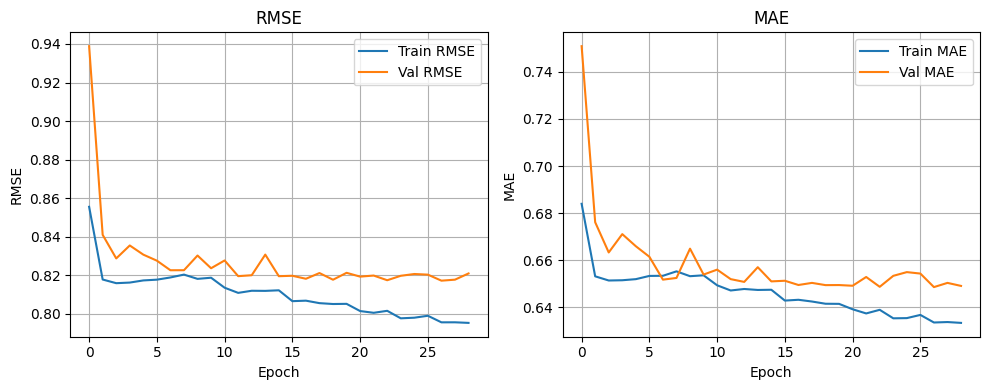

In [ ]:
# @title Plot curves dropping the first epoch
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS-1), train_rmse_history[1:], label='Train RMSE')
plt.plot(range(EPOCHS-1), val_rmse_history[1:], label='Val RMSE')
plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.title('RMSE')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(EPOCHS-1), train_mae_history[1:], label='Train MAE')
plt.plot(range(EPOCHS-1), val_mae_history[1:], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_rmse, test_mae = run_epoch(test_loader, training=False)
print(f"Test RMSE: {test_rmse:.4f} | "
      f"Test MAE: {test_mae:.4f}")

Test RMSE: 0.8171 | Test MAE: 0.6505


In [ ]:
# Inference helper – top-N meals for a given user
model.eval()

@torch.inference_mode()
def recommend(user_id: int, k: int = 10):
    model.eval()
    with torch.inference_mode():
        device = next(model.parameters()).device

        # user and candidate meals
        uid = uid_to_idx[user_id]
        rated = set(ratings.loc[ratings["user_id"] == user_id, "meal_id"])
        cand_ids = meals.loc[~meals["id"].isin(rated), "id"].values
        if cand_ids.size == 0:
            return pd.DataFrame(columns=["id", "title", "score"])

        # Create a temporary DataFrame for candidate meals for this user
        cand_ratings_df = pd.DataFrame({
            'user_id': user_id,
            'meal_id': cand_ids,
            'rating': 0 # Dummy rating, not used in prediction
        })

        # Create a Dataset and DataLoader for the candidate meals
        cand_ds = MealRatingDataset(cand_ratings_df)
        cand_loader = DataLoader(cand_ds, batch_size=BATCH)

        all_scores = []
        # Use the DataLoader to get batches of data
        for batch in cand_loader:
            u_ids_batch = batch["user_id"].to(device)
            m_ids_batch = batch["meal_id"].to(device)
            u_feats_batch = batch["user_feat"].to(device)
            m_feats_batch = batch["meal_feat"].to(device)

            # forward pass
            scores_batch = model(u_ids_batch, m_ids_batch, u_feats_batch, m_feats_batch).cpu().numpy()
            all_scores.extend(scores_batch)

        scores = np.array(all_scores)


        # build result
        top_k = np.argpartition(-scores, k)[:k]
        rec_df = (meals[meals["id"].isin(cand_ids[top_k])]
                [["id", "title"]]
                .assign(score=scores[top_k])
                .sort_values("score", ascending=False))
    return rec_df

# quick demo
recommend(user_id=10, k=5)

,id,title,score
2,2,حمص بطحينة,4.076437
135,135,سمك السلمون بالزعتر والليمون,4.064351
277,277,يخني الفاصوليا الخضراء,4.062026
306,306,سلطة الحمص المتبلة,4.025142
411,411,كباب الدجاج بالزبادي والثوم,4.011355


In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "hybrid_recommender.pt")

# Save artifacts needed for inference
# Include the preprocessors, and the user and meal index maps
joblib.dump({"user_preprocessor": user_preproc,
             "meal_preprocessor": meal_preproc,
             "uid_to_idx": uid_to_idx,
             "mid_to_idx": mid_to_idx
            }, "artifacts_hybrid_recommender.pkl")

print("Saved model + artifacts.")

Saved model + artifacts.


# Explore Embeddings

In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad:
    print(f"Parameter name: {name}")
    print(f"Parameter shape: {param.shape}")
    print("-" * 20)

Parameter name: user_emb.weight
Parameter shape: torch.Size([1698, 32])
--------------------
Parameter name: meal_emb.weight
Parameter shape: torch.Size([459, 32])
--------------------
Parameter name: user_bias.weight
Parameter shape: torch.Size([1698, 1])
--------------------
Parameter name: meal_bias.weight
Parameter shape: torch.Size([459, 1])
--------------------
Parameter name: user_feat_proj.weight
Parameter shape: torch.Size([32, 25])
--------------------
Parameter name: user_feat_proj.bias
Parameter shape: torch.Size([32])
--------------------
Parameter name: meal_feat_proj.weight
Parameter shape: torch.Size([32, 401])
--------------------
Parameter name: meal_feat_proj.bias
Parameter shape: torch.Size([32])
--------------------
Parameter name: transformer.layers.0.self_attn.in_proj_weight
Parameter shape: torch.Size([96, 32])
--------------------
Parameter name: transformer.layers.0.self_attn.in_proj_bias
Parameter shape: torch.Size([96])
--------------------
Parameter name: t

In [ ]:
embs = {}

# @title Extract parameters from the model
for name, param in model.named_parameters():
  if param.requires_grad:
    embs[name[:-len('.weight')]] = param.data

meal_emb = embs['meal_emb']
users_emb = embs['user_emb']

In [ ]:
# @title Top-k meals according to bias
meal_bias = embs['meal_bias'].squeeze()
idxs = meal_bias.argsort(descending=True)[:10]

# Get titles using original ids
original_meal_ids = [idx_to_mid[idx.item()] for idx in idxs]
most_liked_meals = meals[meals['id'].isin(original_meal_ids)]['title'].tolist()

for i, meal in enumerate(most_liked_meals):
  print(f'{i+1}. {meal}')

1. حمص بطحينة
2. سمك السلمون بالزعتر والليمون
3.     شوربة الفطر الكريمية الصحية
4. كوسا باللبن والكزبرة
5. يخني الفاصوليا الخضراء
6. سلطة الحمص المتبلة
7. كوسا محشي بالكينوا والخضار
8.     صينية سمك بالخضار
9.     يخني الفاصوليا الخضراء
10. كباب الدجاج بالزبادي والثوم


In [ ]:
# @title Top-k similar meals to target meal
target_idx = 1 # index of meal to inspect
emb_target = meal_emb[target_idx].unsqueeze(0) # (1, D)
cos_sim = torch.nn.functional.cosine_similarity(
    emb_target, meal_emb, dim=1
)

top_k = 10
top_indices = cos_sim.argsort(descending=True)[:top_k+1]

top_meal_ids = [idx_to_mid[i.item()] for i in top_indices]
top_titles   = (
    meals[meals["id"].isin(top_meal_ids)]
         .set_index("id")
         .loc[top_meal_ids]["title"]
         .tolist()
)

original_title = meals[meals["id"] == idx_to_mid[target_idx]]["title"].iloc[0]
print(f"Meals similar to '{original_title}':")
for rank, title in enumerate(top_titles[1:], 1):
    print(f"{rank}. {title}")

Meals similar to 'مسخن':
1. شوربة عدس أحمر
2. مشاوي مشكلة
3.     كفتة الدجاج المشوية
4. فتة العدس بالخبز المحمص
5. مناقيش الزعتر بالطحين الأسمر
6. لحم بقري مشوي مع الخضار
7. قدرة الدجاج الصحية
8.     فول بالزيت والليمون
9. شوربة الفطر بالشعيرية السمراء
10. سلطة تبولة الكينوا


#### Plotting Embeddings

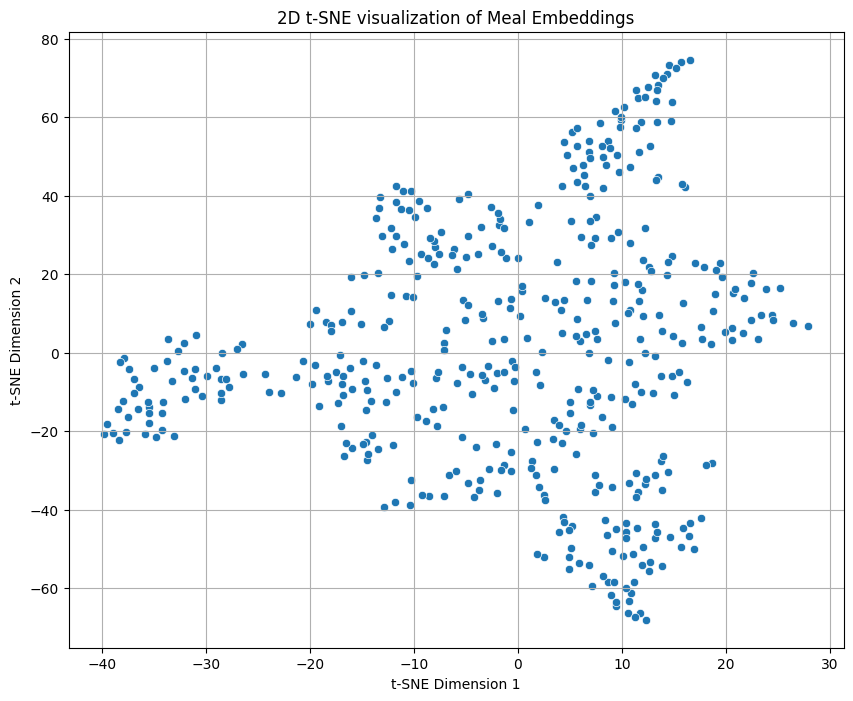

In [ ]:
# @title Plot meal embeddings
# Convert meal_emb tensor to numpy array
meal_embeddings_np = meal_emb.cpu().numpy()

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
meal_embeddings_2d = tsne.fit_transform(meal_embeddings_np)

# Create a DataFrame for plotting
meal_embeddings_df = pd.DataFrame(meal_embeddings_2d, columns=['tsne_dim1', 'tsne_dim2'])

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=meal_embeddings_df, x='tsne_dim1', y='tsne_dim2')
plt.title('2D t-SNE visualization of Meal Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

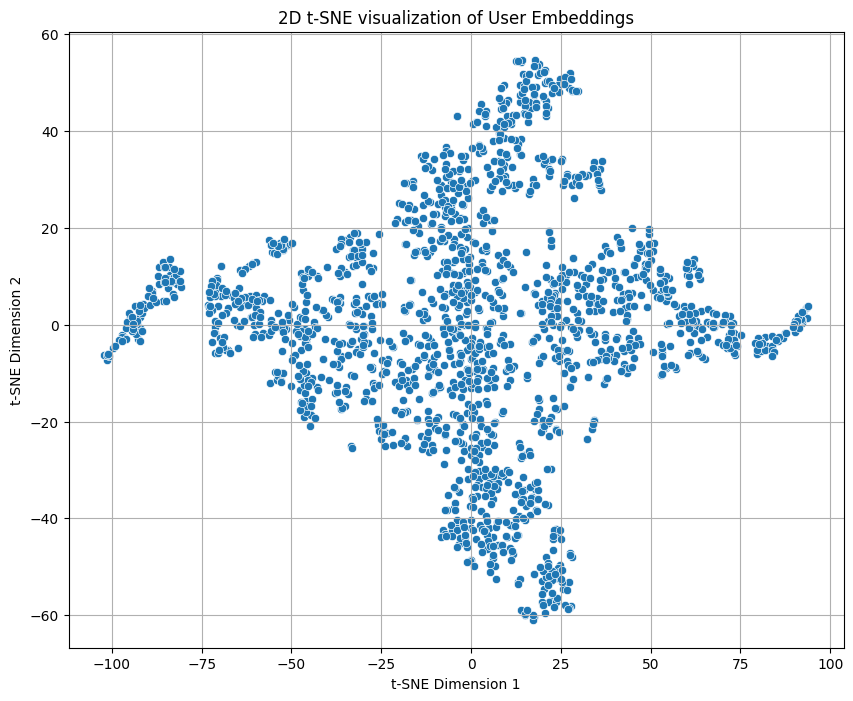

In [ ]:
# @title Plot user embeddings
# Convert user_factors tensor to numpy array
user_embeddings_np = users_emb.cpu().numpy()

# Apply t-SNE to reduce dimensions to 2
tsne_users = TSNE(n_components=2, random_state=42, perplexity=10)
user_embeddings_2d = tsne_users.fit_transform(user_embeddings_np)

# Create a DataFrame for plotting
user_embeddings_df = pd.DataFrame(user_embeddings_2d, columns=['tsne_dim1', 'tsne_dim2'])

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=user_embeddings_df, x='tsne_dim1', y='tsne_dim2')
plt.title('2D t-SNE visualization of User Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

# Retrieval Model

In [6]:
interaction_df = pd.read_csv("interactions.csv")
interaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78820 entries, 0 to 78819
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      78820 non-null  int64
 1   meal_id      78820 non-null  int64
 2   interaction  78820 non-null  int64
dtypes: int64(3)
memory usage: 1.8 MB


In [7]:
# Split the data into train and validation sets
train_interaction_df, val_interaction_df = train_test_split(
    interaction_df, test_size=0.2, random_state=42)

In [8]:
# @title Interaction dataset
class InteractionDataset(Dataset):
    def __init__(self, user_ids, meal_ids, labels):
        self.user_ids = user_ids
        self.meal_ids = meal_ids
        self.labels = labels

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        u = self.user_ids[idx]
        m = self.meal_ids[idx]
        y = self.labels[idx]
        return torch.tensor(u, dtype=torch.long), \
               torch.tensor(m, dtype=torch.long), \
               torch.tensor(y, dtype=torch.float)


def collate_fn(batch):
    """Stack tuples into tensors."""
    user, meal, label = zip(*batch)
    return torch.stack(user), torch.stack(meal), torch.stack(label)

train_ds = InteractionDataset(train_interaction_df["user_id"].values,
                            train_interaction_df["meal_id"].values,
                            train_interaction_df["interaction"].values)
val_ds   = InteractionDataset(val_interaction_df["user_id"].values,
                            val_interaction_df["meal_id"].values,
                            val_interaction_df["interaction"].values)

BATCH = 512

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                            collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                            collate_fn=collate_fn)

In [12]:
# @title RetrievalNet
class RetrievalNet(nn.Module):
    """
    Two-tower retrieval model that re-uses the embeddings
    already trained by HybridRecommender.
    """
    def __init__(self, base: HybridRecommender):
        super().__init__()
        self.user_emb = base.user_emb
        self.meal_emb = base.meal_emb
        # small MLP on top of each tower
        d = base.user_emb.embedding_dim
        self.user_tower  = nn.Sequential(
            nn.Linear(d, d), nn.ReLU(), nn.Linear(d, d)
        )
        self.meal_tower  = nn.Sequential(
            nn.Linear(d, d), nn.ReLU(), nn.Linear(d, d)
        )
        # final dot-product + optional temperature
        # high temperature → scores are small and evenly spread
        # low temperature → scores are large and the model becomes more confident in its top choices
        self.temperature = nn.Parameter(torch.tensor(1.0))

    def forward(self, user_ids, meal_ids):
        u = self.user_tower(self.user_emb(user_ids))
        m = self.meal_tower(self.meal_emb(meal_ids))
        return F.cosine_similarity(u, m, dim=-1) * self.temperature

In [ ]:
# Train setup
def train_one_epoch(model, loader, optim, device):
    model.train()
    total_loss = 0.0
    labels, preds = [], []
    for user, meal, label in loader:
        user, meal, label = user.to(device), meal.to(device), label.to(device)
        optim.zero_grad()
        logits = model(user, meal)
        loss = F.binary_cross_entropy_with_logits(logits, label)
        loss.backward()
        optim.step()
        total_loss += loss.item() * user.size(0)

        labels.append(label.cpu())
        preds.append(torch.sigmoid(logits).cpu())

    labels = torch.cat(labels)
    preds = torch.cat(preds)
    auc = roc_auc_score(labels.detach().numpy(), preds.detach().numpy())

    return total_loss / len(loader.dataset), auc


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    labels, preds = [], []
    total_loss = 0.0
    for user, meal, label in loader:
        user, meal, label = user.to(device), meal.to(device), label.to(device)
        logits = model(user, meal)
        loss = F.binary_cross_entropy_with_logits(logits, label)
        total_loss += loss.item() * user.size(0)
        labels.append(label.cpu())
        preds.append(torch.sigmoid(logits).cpu())
    labels = torch.cat(labels)
    preds = torch.cat(preds)

    # Calculate metrics
    auc = roc_auc_score(labels.detach().numpy(), preds.detach().numpy())
    # Convert probabilities to binary predictions (using 0.5 as threshold)
    binary_preds = (preds.detach().numpy() > 0.5).astype(int)
    accuracy = accuracy_score(labels.detach().numpy(), binary_preds)
    f1 = f1_score(labels.detach().numpy(), binary_preds)
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, auc, accuracy, f1

def recommend_retrieval(user_id: int, k: int = 10, device="cpu"):
    with torch.no_grad():
        retrieval_model.eval()
        if user_id not in uid_to_idx:
            print(f"User {user_id} not found in the dataset.")
            return pd.DataFrame(columns=["id", "title", "score"])

        user_idx = uid_to_idx[user_id]
        user_tensor = torch.tensor([user_idx], device=device)

        # Get all meal indices
        all_meals_tensor = torch.arange(len(mid_to_idx), device=device)

        # Get scores for all meals for the given user
        scores = torch.sigmoid(retrieval_model(user_tensor, all_meals_tensor))  # (N_MEALS,)

        # Get top-k meal indices based on scores
        topk = torch.topk(scores, k=k)
        top_meal_indices = topk.indices.tolist()
        top_scores = topk.values.tolist()

        # Map indices back to original meal IDs
        top_meal_ids = [idx_to_mid[idx] for idx in top_meal_indices]

        # Create a DataFrame with recommended meal titles and scores
        recommended_meals = meals[meals["id"].isin(top_meal_ids)].set_index("id").loc[top_meal_ids]
        recommended_meals["score"] = top_scores

        return recommended_meals[["title", "score"]]

In [ ]:
# @title Initialize model
EMBED_DIM = 32
EPOCHS = 5
LR = 2e-2

# Reuse the trained HybridRecommender model
model.eval()
retrieval_model = RetrievalNet(model).to(device)
optim = torch.optim.AdamW(retrieval_model.parameters(), lr=LR)

In [ ]:
# @title Train
train_losses, train_aucs, val_losses, val_aucs, val_accuracies, val_f1s = [], [], [], [], [], []
for epoch in range(1, EPOCHS + 1):
    val_loss, val_auc, accuracy, f1 = evaluate(retrieval_model, val_loader, device)
    train_loss, train_auc = train_one_epoch(retrieval_model, train_loader, optim, device)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    val_accuracies.append(accuracy)
    val_f1s.append(f1)
    print(f"Epoch {epoch:02d} | train-loss {train_loss:.4f} | val-loss {val_loss:.4f} | train-AUC {train_auc:.4f} | val-AUC {val_auc:.4f} | val-Accuracy {accuracy:.4f} | val-F1 {f1:.4f}")

Epoch 01 | train-loss 0.2375 | val-loss 0.7151 | train-AUC 0.9103 | val-AUC 0.5100 | val-Accuracy 0.3789 | val-F1 0.4618
Epoch 02 | train-loss 0.1617 | val-loss 0.1706 | train-AUC 0.9322 | val-AUC 0.9105 | val-Accuracy 0.9690 | val-F1 0.9818
Epoch 03 | train-loss 0.1485 | val-loss 0.1617 | train-AUC 0.9399 | val-AUC 0.9120 | val-Accuracy 0.9687 | val-F1 0.9817
Epoch 04 | train-loss 0.1406 | val-loss 0.1526 | train-AUC 0.9437 | val-AUC 0.9109 | val-Accuracy 0.9689 | val-F1 0.9818
Epoch 05 | train-loss 0.1360 | val-loss 0.1490 | train-AUC 0.9454 | val-AUC 0.9122 | val-Accuracy 0.9688 | val-F1 0.9817


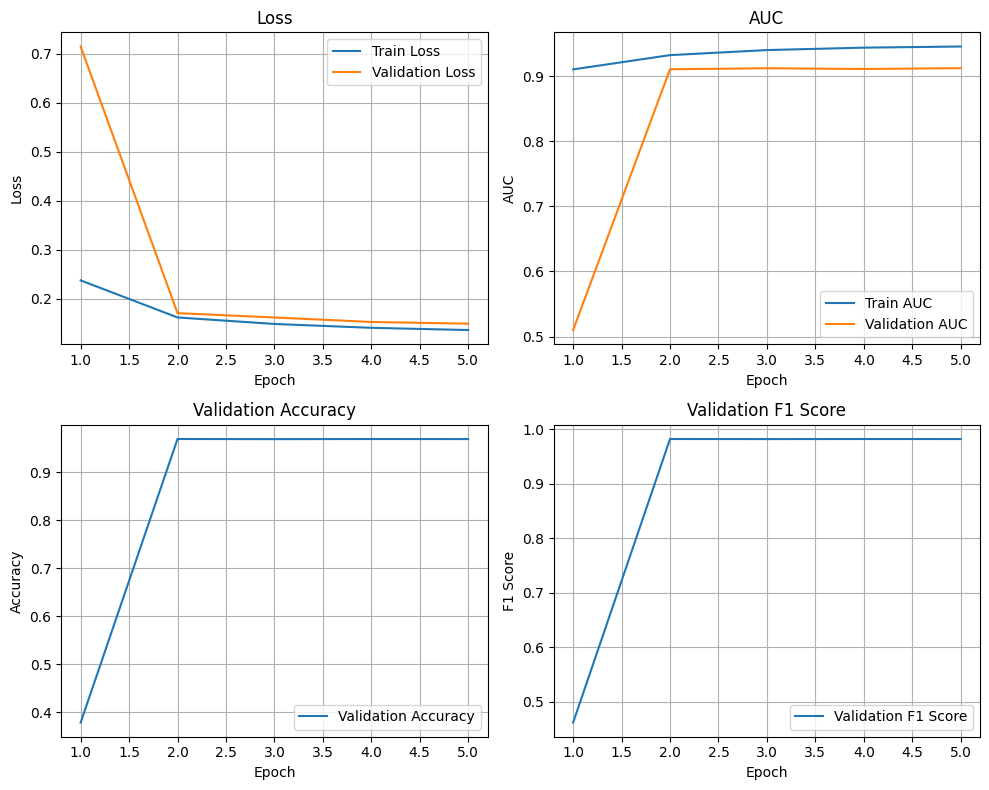

In [ ]:
# @title Plot curves
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_aucs, label='Train AUC')
plt.plot(range(1, EPOCHS + 1), val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS + 1), val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# quick top-K demo for user idx
retrieval_model.eval()
user_id = 42 # Original user ID
recommended_meals_df = recommend_retrieval(user_id=user_id, k=10, device=device)
print(f"Top-10 recommended meals for user {user_id}:")
display(recommended_meals_df)

Top-10 recommended meals for user 42:


,title,score
id,,
270,قرنبيط باللحمة والصنوبر,0.980166
425,فول بالطحينة والليمون,0.979892
450,شيش طاووق مشوي,0.979730
373,مفروكة الفستق الحلبي,0.978982
21,دولمة ورق عنب نباتي,0.978138
337,حمص بالبنجر والليمون,0.978053
263,مجدّرة الفريكة,0.977854
342,مقلوبة الزهرة والدجاج,0.977641
262,فول بالليمون والزيت,0.977277


In [ ]:
# Save model
torch.save(retrieval_model.state_dict(), "retrieval.pt")

In [ ]:
# @title Two-stage Hybrid Recommendation Function
@torch.no_grad()
def recommend_hybrid_retrieval(user_id: int, k: int = 10, num_candidates: int = 50, device="cpu"):
    retrieval_model.eval()
    model.eval()

    if user_id not in uid_to_idx:
        print(f"User {user_id} not found in the dataset.")
        return pd.DataFrame(columns=["id", "title", "score"])

    user_idx = uid_to_idx[user_id]
    user_tensor = torch.tensor([user_idx], device=device)

    # Stage 1: Retrieval (get initial candidates)
    all_meals_tensor = torch.arange(len(mid_to_idx), device=device)
    retrieval_scores = torch.sigmoid(retrieval_model(user_tensor, all_meals_tensor))

    # Get top_candidates meal indices from the retrieval model
    top_candidate_indices = torch.topk(retrieval_scores, k=num_candidates).indices.tolist()
    candidate_meal_ids = [idx_to_mid[idx] for idx in top_candidate_indices]

    # Filter out meals the user has already rated
    rated_meal_ids = set(ratings.loc[ratings["user_id"] == user_id, "meal_id"])
    candidate_meal_ids = [meal_id for meal_id in candidate_meal_ids if meal_id not in rated_meal_ids]

    if not candidate_meal_ids:
      print(f"No new candidate meals found for user {user_id}.")
      return pd.DataFrame(columns=["id", "title", "score"])

    # Stage 2: Reranking (use Hybrid model on candidates)

    # Create a temporary DataFrame for candidate meals for this user for the Hybrid model
    cand_ratings_df = pd.DataFrame({
        'user_id': user_id,
        'meal_id': candidate_meal_ids,
        'rating': 0 # Dummy rating, not used in prediction
    })

    # Create a Dataset and DataLoader for the candidate meals
    cand_ds = MealRatingDataset(cand_ratings_df)
    cand_loader = DataLoader(cand_ds, batch_size=hyperparams["batch"]) # Use hybrid model batch size

    all_rerank_scores = []
    # Use the DataLoader to get batches of data
    for batch in cand_loader:
        u_ids_batch = batch["user_id"].to(device)
        m_ids_batch = batch["meal_id"].to(device)
        u_feats_batch = batch["user_feat"].to(device)
        m_feats_batch = batch["meal_feat"].to(device)

        # forward pass through the hybrid model
        scores_batch = model(u_ids_batch, m_ids_batch, u_feats_batch, m_feats_batch).cpu().numpy()
        all_rerank_scores.extend(scores_batch)

    rerank_scores = np.array(all_rerank_scores)

    # Get top-k indices from the reranked scores
    top_k_indices = np.argpartition(-rerank_scores, k)[:k]

    # Get the corresponding meal IDs and scores
    final_recommendation_ids = [candidate_meal_ids[i] for i in top_k_indices]
    final_recommendation_scores = rerank_scores[top_k_indices]

    # Create a DataFrame with recommended meal IDs and scores
    recommended_meals_df = pd.DataFrame({
        'id': final_recommendation_ids,
        'score': final_recommendation_scores
    })

    # Return meal IDs and scores
    return recommended_meals_df.sort_values("score", ascending=False).reset_index(drop=True)

In [ ]:
recommend_hybrid_retrieval(1697)

,id,score
0,333,3.576714
1,221,3.488976
2,297,3.488181
3,381,3.465989
4,354,3.455047
5,161,3.435511
6,296,3.414008
7,230,3.385542
8,216,3.372198
9,286,3.368916
